In [1]:
import hopsworks
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os


In [2]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/188564
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
wine_fg = fs.get_feature_group(name="wine", version=1)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(
    name="wine", 
    version=1, 
    description="Read from wine dataset",
    labels=["quality"],
    query=query)
    

In [4]:
while True:
    X_train, X_test, y_train, y_test = feature_view.train_test_split(0.3)
    if 9 in y_test['quality'].values and 3 in y_test['quality'].values and 3 in y_train['quality'].values and 9 in y_train['quality'].values: 
        break

Finished: Reading data from Hopsworks, using ArrowFlight (1.35s) 


See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)


In [6]:
model = KNeighborsClassifier(n_neighbors=9)
model.fit(X_train, y_train.values.ravel())

See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)


KNeighborsClassifier(n_neighbors=9)

In [7]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
metrics = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)


In [8]:
print(metrics)
print(accuracy)

{'3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 12}, '4': {'precision': 0.2, 'recall': 0.02830188679245283, 'f1-score': 0.049586776859504134, 'support': 106}, '5': {'precision': 0.5332640332640333, 'recall': 0.580973952434881, 'f1-score': 0.5560975609756098, 'support': 883}, '6': {'precision': 0.5060080106809078, 'recall': 0.6152597402597403, 'f1-score': 0.5553113553113553, 'support': 1232}, '7': {'precision': 0.3801369863013699, 'recall': 0.25517241379310346, 'f1-score': 0.30536451169188444, 'support': 435}, '8': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 93}, '9': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6}, 'accuracy': 0.5005421033610409, 'macro avg': {'precision': 0.23134414717804444, 'recall': 0.21138685618288253, 'f1-score': 0.20948002926262196, 'support': 2767}, 'weighted avg': {'precision': 0.4628961328413862, 'recall': 0.5005421033610409, 'f1-score': 0.47461781605281184, 'support': 2767}}
0.5005421033610409


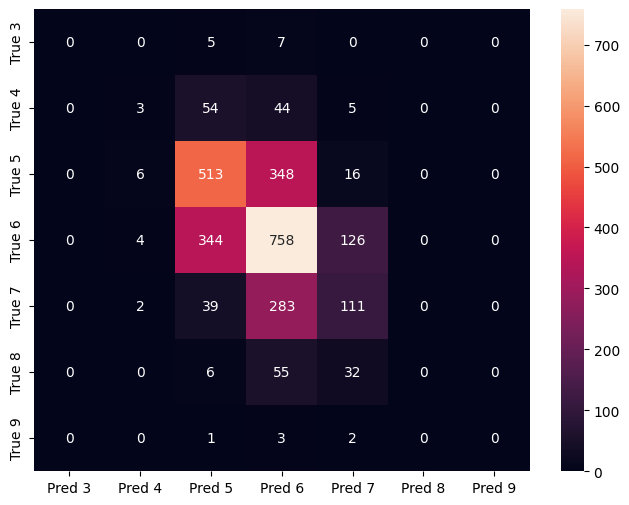

In [9]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(conf_matrix, ["True 3", "True 4", "True 5", "True 6", "True 7", "True 8", "True 9"], 
                     ["Pred 3", "Pred 4", "Pred 5", "Pred 6", "Pred 7", "Pred 8", "Pred 9"])

plt.figure(figsize=(8, 6))
cm = sns.heatmap(df_cm, annot=True, fmt='.0f')
fig = cm.get_figure()
plt.show()

In [10]:
mr = project.get_model_registry()

model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save model and confusion matrix to the model dir
joblib.dump(model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")

input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, description, metrics
wine_model = mr.python.create_model(
    name="wine_model",
    metrics={"accuracy": metrics["accuracy"]},
    model_schema=model_schema,
    description="Wine quality predictor"
)

# Upload the model to the model registry
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/31360 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/864998 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/683 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/188564/models/wine_model/2


Model(name: 'wine_model', version: 2)